# HousePrice-Prediction with Regression Techniques
## About
Data-Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [26]:
# imports
import os
import pandas as pd
import numpy as np
import sklearn
%matplotlib inline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
sns.set()
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

First quick look on the data:

In [27]:
print("Size Training: %d, Size test: %d" %(len(train_df), len(test_df)))
print(train_df.head(3))

Size Training: 1460, Size test: 1459
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  

[3 rows x 81 columns]


## Data preparation
Before training and evaluating any model on the data, the datasets have to be prepared.

### Missing Values
First, the missing values should be eliminated. To do so, I will concatenate the training and test data first and remove/impute the missing values in the next steps.
Let's have a look at the missing values for each feature first. I will limit the analysis to all features where the ratio of nan-values is greater than 0.5%:
* **PoolQC**: Only 0.3% of the entries have a value for the pool quality. According to the description, NaN values is equal to 'no pool available' though and thus can be translated to this value.
* **MiscFeature**: Includes different values like Elevator, 2nd garage etc. that are not represented by a separate feature. Nan means there is no such special value at all. This feature could probably be transformed with OneHot-Encoding.
* **Alley/Fence/FireplaceQu/GarageFinish/GarageQual/GarageCond/GarageYrBlt/GarageType/BsmtCont/BsmtExposure/BsmtQual/BsmtFinType1/BsmtFinType2/MasVnrType/MasVnrArea**: Defines the type of this category. NaN means there isn't such an item at all, so the missing values can be translated to 'not available' or 'not applicable'.
* **LotFrontage**: The distance between the street and the house should be similar within the same neighborhood. Therefore I will calculate the median (mean is probably to sensitive for outliers here) and use it to fill the missing values.

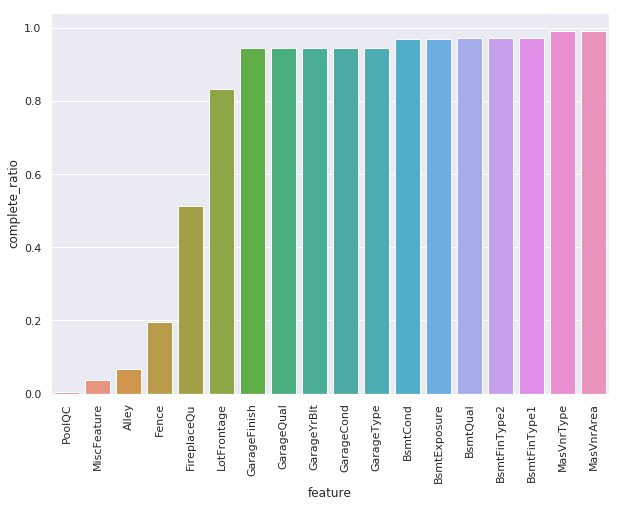

In [127]:
complete_df = pd.concat([train_df, test_df]).reset_index(drop=True).drop('SalePrice', axis=1)

missing_df = pd.DataFrame(columns=['feature', 'complete_ratio'])
for feature in complete_df.columns:
    complete_ratio = len(complete_df[feature].dropna()) / length_complete
    missing_df.loc[len(missing_df) + 1] = [feature, complete_ratio]
 

f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
rel_missing = missing_df[missing_df['complete_ratio'] <= 0.995].sort_values('complete_ratio', ascending=True)
sns.barplot(rel_missing['feature'], rel_missing['complete_ratio'])

As explained above, there exists a simple possibility to fill the missing values in most cases. This will be done for the features where the ratio of missing values is greater than 0.5%. After that, I decided to drop the remaining missing values since this reduces the size of the dataset only by 13 entries from 2919 to 2106.

In [128]:
# replace NaN by 'None' where applicable
none_columns = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish',
               'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'MiscFeature', 'MasVnrType']
complete_df_none = complete_df.copy()
for none_column in none_columns:
    complete_df_none[none_column] = complete_df_none[none_column].fillna('none')
    
# replace NaN by 0 where applicable
none_columns = ['BsmtFinType1', 'BsmtFinType2', 'MasVnrArea']
for none_column in none_columns:
    complete_df_none[none_column] = complete_df_none[none_column].fillna(0)
    
# Fill LotFrontage
neighboor_lf = complete_df_none.groupby('Neighborhood')['LotFrontage'].agg('median').reset_index()
neighboor_lf.columns = ['Neighborhood','median_dis']

def replace_na(r):
    neighborhood = r['Neighborhood']
    lf = r['LotFrontage']
    if pd.isnull(lf):
        return neighboor_lf[neighboor_lf['Neighborhood'] == neighborhood]['median_dis'].values[0]
    else:
        return lf

complete_df_none['LotFrontage'] = complete_df_none.apply(lambda x: replace_na(x), axis=1)

# one hot encoding for MiscFeature
print(set(complete_df_none['MiscFeature'].values))
complete_df_none = pd.concat([complete_df_none, pd.get_dummies(complete_df_none['MiscFeature'])], axis=1)
complete_df_none.drop('MiscFeature', axis=1)

# check ratio of nans again
missing_df2 = pd.DataFrame(columns=['feature', 'complete_ratio'])
for feature in complete_df_none.columns:
    complete_ratio = len(complete_df_none[feature].dropna()) / length_complete
    missing_df2.loc[len(missing_df2) + 1] = [feature, complete_ratio]
print(missing_df2[missing_df2['complete_ratio'] <= 0.995].sort_values('complete_ratio', ascending=True)) 

# drop remaining missing values
print(len(complete_df_none))
print(len(complete_df_none.dropna()))
complete_df_none.dropna(inplace=True)

{'TenC', 'Gar2', 'none', 'Shed', 'Othr'}
Empty DataFrame
Columns: [feature, complete_ratio]
Index: []
2919
2906


### Outlier Detection

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

/home/dennis/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


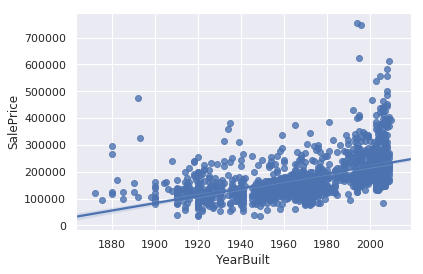

In [29]:
print(train_df.columns)
sns.regplot(train_df['YearBuilt'], train_df['SalePrice'])

### Target Variable

Interpreting and evaluating the model will be easier if the target variable is normally distributed. Thus I will check whether this is fulfilled by plotting its distribution and the QQ-Plot. Findings:
* The first plot shows that the data is right skewed
* The QQ-Plot confirms that the data is not normally distributed.

/home/dennis/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


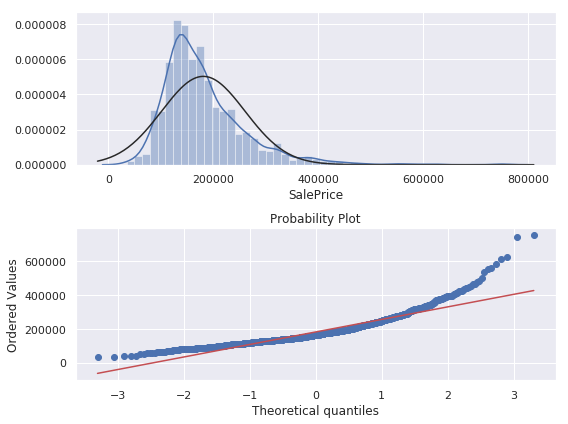

In [14]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(train_df['SalePrice'], fit=norm, ax=ax1)

res = stats.probplot(train_df['SalePrice'], plot=ax2)
fig.tight_layout()
plt.show()

To solve this, I will apply the log-log-transformation on the target variable.
As a result, one can see that the distribution of the SalesPrices appears more normally distributed now. 

/home/dennis/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


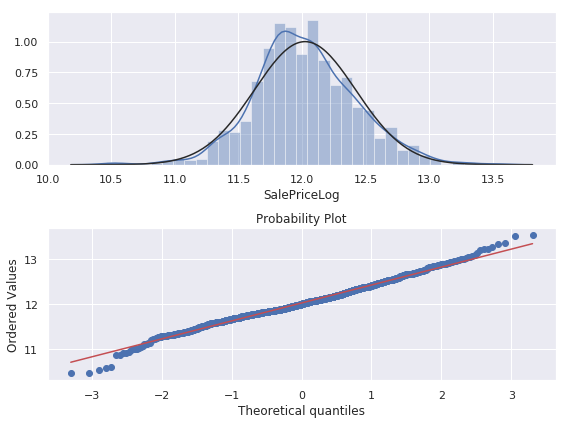

In [15]:
# use log to transform the dependent variable
train_df['SalePriceLog'] = np.log1p(train_df['SalePrice'])

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(train_df['SalePriceLog'], fit=norm, ax=ax1)

res = stats.probplot(train_df['SalePriceLog'], plot=ax2)
fig.tight_layout()
plt.show()